# **Game Recommendation System**

The dataset contains over 41 million cleaned and preprocessed user recommendations (reviews) from a Steam Store.

**games.csv** - a table of games (or add-ons) information on ratings, pricing in US dollars $, release date, etc. A piece of extra non-tabular details on games, such as descriptions and tags, is in a metadata file;

**users.csv** - a table of user profiles' public information: the number of purchased products and reviews published;

**recommendations.csv** - a table of user reviews: whether the user recommends a product. The table represents a many-many relation between a game entity and a user entity.

> # **Libraries**

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, hstack
from sklearn.neighbors import NearestNeighbors

import json

import warnings
warnings.filterwarnings('ignore')
import os
data_fold = r"C:\Users\User\Downloads\archive (2)"
for dirname, _, filenames in os.walk(data_fold):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\User\Downloads\archive (2)\games.csv
C:\Users\User\Downloads\archive (2)\games_metadata.json
C:\Users\User\Downloads\archive (2)\recommendations.csv
C:\Users\User\Downloads\archive (2)\users.csv


> # **Data Collection**

In [4]:
data_fold = r"C:\Users\User\Downloads\archive (2)"

game_df = pd.read_csv(data_fold + '/games.csv')
user_df = pd.read_csv(data_fold + '/users.csv')
recommend_df = pd.read_csv(data_fold + '/recommendations.csv')

In [5]:
game_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [6]:
user_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [7]:
recommend_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [9]:
games_metadata_df = pd.read_json(data_fold + '/games_metadata.json', lines=True)
games_metadata_df.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [10]:
dataframes = {
    'game_df' : game_df,
    'users_df' : user_df,
    'recommend_df' : recommend_df
}

for name, df in dataframes.items():
    print(f"\nNull values in {name} :\n{df.isna().sum()}")

    df_dimension = df.shape

    print(f"Dimension of {name}: {df_dimension}")

n_games = game_df['app_id'].nunique()
n_users = user_df['user_id'].nunique()
n_reviews = len(recommend_df)

unique_review_values = recommend_df['is_recommended'].unique()

print('\nNumber of unique values in game_df: ', n_games)
print('Number of unique values in users_df: ', n_users)
print('Full review matrix will have : ', n_games * n_users)
print('-' * 20)
print("Unique Review values (is_recommended) : ", unique_review_values)
print('Number of reviews : ', n_reviews)
print(n_reviews / (n_games * n_users) * 100, '% of the review matrix is filled')


Null values in game_df :
app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64
Dimension of game_df: (50872, 13)

Null values in users_df :
user_id     0
products    0
reviews     0
dtype: int64
Dimension of users_df: (14306064, 3)

Null values in recommend_df :
app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64
Dimension of recommend_df: (41154794, 8)

Number of unique values in game_df:  50872
Number of unique values in users_df:  14306064
Full review matrix will have :  727778087808
--------------------
Unique Review values (is_recommended) :  [ True False]
Number of reviews :  41154794
0.005654854781895731 % of the review matrix is filled


> # **Data Preprocessing**

> ## **Games Dataset**

We will filter game_df dataset so that it helps with our recommendation model, eg:

- **Platform** : Games that do not support Windows OS will be filtered out since most games are compatible with Windows

- **Price** : Filtering out games based on price (less than 3$ might be demos, more than 70 might be triple A games), and free games

- **Ratings** : Filter out game with ratings of "Overwhelmingly negative" or "very negative"

In [11]:
def clean_game_dataset(game_df):
    clean_game_price_df = game_df[
        ((game_df['price_original']) == 0.00) | ((game_df['price_original'] >= 2.99) & (game_df['price_original'] <= 70.00))
    ]
    print('Original game_df dimension : ', game_df.shape)
    print('Filtered price_original game_df dimension : ', clean_game_price_df.shape)

    clean_game_platform_df = clean_game_price_df[
        clean_game_price_df['win']
    ]
    print('Filtered Windows platform game_df dimension : ', clean_game_platform_df.shape)

    ratings_to_filter = ['Overwhelmingly Negative', 'Very Negative']
    clean_game_ratings_df = clean_game_platform_df[
        ~clean_game_platform_df['rating'].isin(ratings_to_filter)
    ]
    print('Filtered negative ratings game_df dimension : ', clean_game_ratings_df.shape)

    return clean_game_ratings_df

In [12]:
# Preprocess game_df
clean_game_df = clean_game_dataset(game_df)

Original game_df dimension :  (50872, 13)
Filtered price_original game_df dimension :  (44202, 13)
Filtered Windows platform game_df dimension :  (43475, 13)
Filtered negative ratings game_df dimension :  (43405, 13)


> ## **User Dataset**

In [13]:
user_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [14]:
pd.set_option('display.float_format', '{:.2f}'.format)
user_df.drop(columns = 'user_id').describe()

,products,reviews
count,14306064.00,14306064.00
mean,116.37,2.88
std,243.85,7.99
min,0.00,0.00
25%,23.00,1.00
50%,55.00,1.00
75%,127.00,3.00
max,32214.00,6045.00


The **maximum number of products** a user bought as shown was **32,214**, as well as the **maximum number of reviews** a user has given was **6,045**.

The **average number of products** user bought were around **116**, whereas the **average number of reviews** a user has given was around **2 to 3 reviews**.

In [15]:
def thresholds(dataframe, column_name: str, moderate_outlier = True):
    Q1 = dataframe[column_name].quantile(.25)
    Q2 = dataframe[column_name].quantile(.5)
    Q3 = dataframe[column_name].quantile(.75)

    IQR = Q3 - Q1

    multiplier = 1.5 if moderate_outlier else 3
    left_threshold = Q1 - multiplier * IQR
    right_threshold = Q3 + multiplier * IQR
    print(left_threshold, ', ', right_threshold)

    return left_threshold, right_threshold

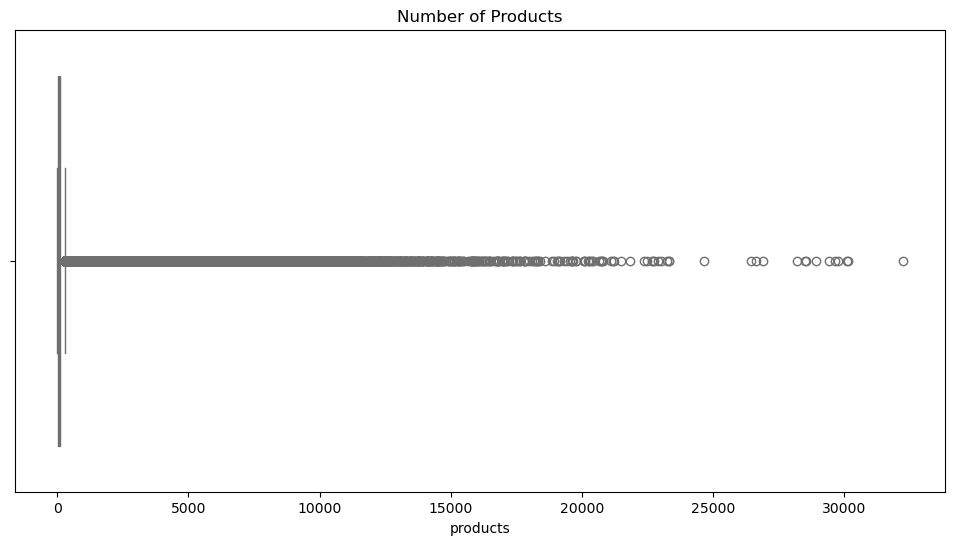

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=user_df['products'], color="skyblue")
plt.title('Number of Products')
plt.show()

In [18]:
min_product_threshold, max_product_threshold = thresholds(user_df, 'products')

-133.0 ,  283.0


In [19]:
def threshold_filtering(dataframe, column_name : str, min_threshold: float, max_threshold : float):
    clean_dataframe = dataframe[
        (dataframe[column_name] > min_threshold) &
        (dataframe[column_name] <= max_threshold)
    ]

    print("Before threshold filter : ", dataframe.shape)
    print("After threshold filter : ", clean_dataframe.shape)
    return clean_dataframe

In [20]:
clean_user_product_df = threshold_filtering(
    user_df, 'products', min_threshold = 0, max_threshold = max_product_threshold
)

Before threshold filter :  (14306064, 3)
After threshold filter :  (12909300, 3)


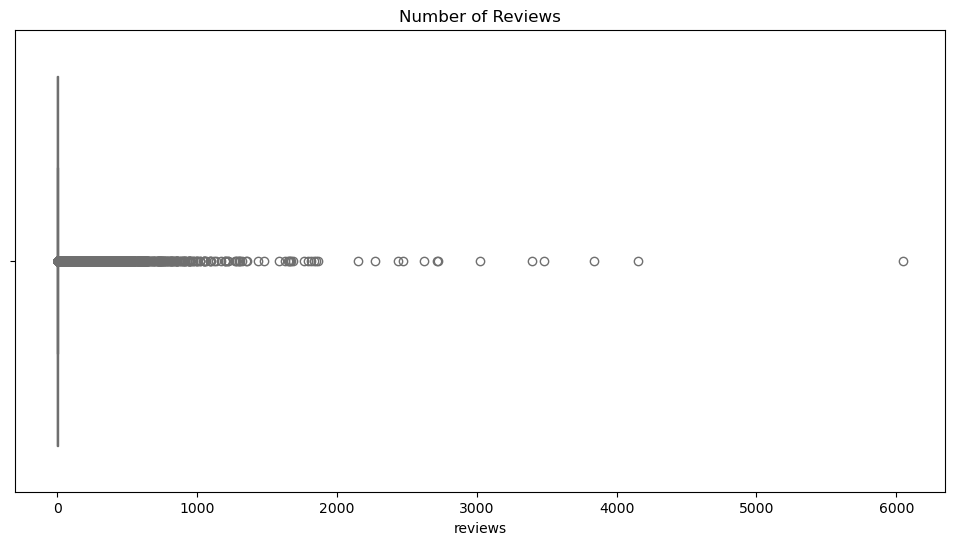

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x = user_df['reviews'], color = "skyblue")
plt.title('Number of Reviews')
plt.show()

In [22]:

min_review_threshold, max_review_threshold = thresholds(
    clean_user_product_df, 'reviews', moderate_outlier = False
)

clean_user_df = threshold_filtering(
    clean_user_product_df, 'reviews', min_threshold = 0, max_threshold = max_review_threshold
)

-2.0 ,  5.0
Before threshold filter :  (12909300, 3)
After threshold filter :  (11336988, 3)


> ## **Recommend Dataset**

In [23]:
recommend_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.30,51580,0
1,304390,4,0,2017-02-17,False,11.50,2586,1
2,1085660,2,0,2019-11-17,True,336.50,253880,2
3,703080,0,0,2022-09-23,True,27.40,259432,3
4,526870,0,0,2021-01-10,True,7.90,23869,4


In [24]:
recommend_df.hours.describe()

count   41154794.00
mean         100.60
std          176.17
min            0.00
25%            7.80
50%           27.30
75%           99.20
max         1000.00
Name: hours, dtype: float64

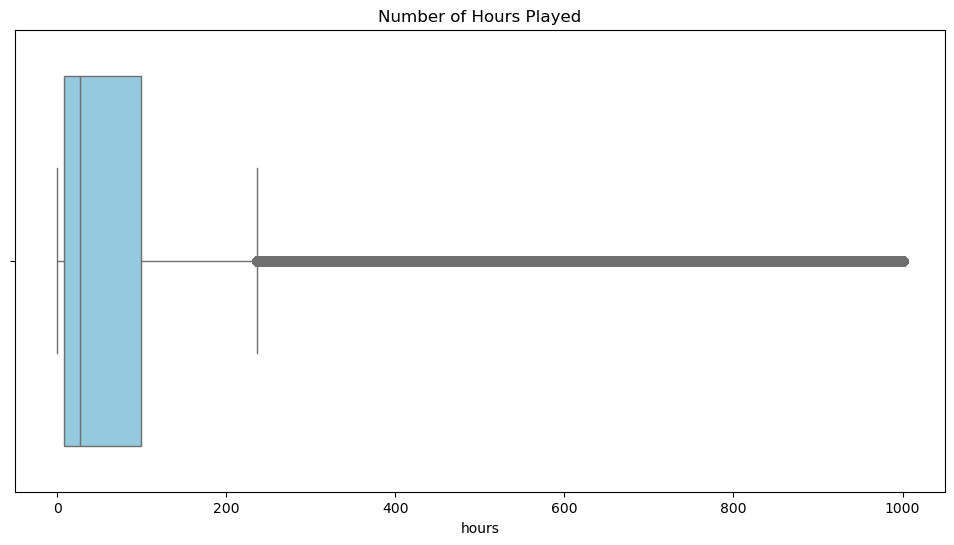

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x = recommend_df.hours, color = "skyblue")
plt.title('Number of Hours Played')
plt.show()

In [27]:
min_hours_played_threshold, max_hours_played_threshold = thresholds(
    recommend_df, 'hours', moderate_outlier = True
)

clean_recommend_df = threshold_filtering(
    recommend_df, 'hours', min_threshold = 3, max_threshold = max_hours_played_threshold
)

-129.3 ,  236.3
Before threshold filter :  (41154794, 8)
After threshold filter :  (30614240, 8)


> ## **Final Recommendation Dataset**

We will remove the game and users from recommendations dataset (clean_recommend_df) that are filtered out.

Cleaned Dataframes = clean_game_df, clean_user_df, clean_recommend_df

In [28]:
clean_recommendations = clean_recommend_df[
    (clean_recommend_df['app_id'].isin(clean_game_df['app_id'])) &
    (clean_recommend_df['user_id'].isin(clean_user_df['user_id']))
]

print('Recommendation Dataset before filtering : ', clean_recommend_df.shape)
print('Recommendation Dataset after filtering : ', clean_recommendations.shape)

Recommendation Dataset before filtering :  (30614240, 8)
Recommendation Dataset after filtering :  (13798007, 8)


These are the reviews from recommend_df which is filtered based on :

- game-filtering conditions for recommendation (price, platform compatability, reviews)

- the amount of products users bought

- the number of reviews given

- hours played for the game so reviews are more genuine


In [29]:
clean_recommendations.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.30,51580,0
1,304390,4,0,2017-02-17,False,11.50,2586,1
3,703080,0,0,2022-09-23,True,27.40,259432,3
4,526870,0,0,2021-01-10,True,7.90,23869,4
5,306130,0,0,2021-10-10,True,8.60,45425,5


> ## **Game Metadata Dataset**

In [30]:
clean_games_metadata_df = games_metadata_df[
    games_metadata_df['app_id'].isin(clean_game_df['app_id'])
]

print("Game Metadata dataset before filtering : ", games_metadata_df.shape)
print("Game Metadata dataset after filtering : ", clean_games_metadata_df.shape)

Game Metadata dataset before filtering :  (50872, 3)
Game Metadata dataset after filtering :  (43405, 3)


In [31]:
games_metadata_df.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


> # **Content-based Filtering**

> ## **Dataset Preparation**

In [32]:
games_with_info = pd.merge(
    clean_game_df, clean_games_metadata_df, on = 'app_id', how = 'inner'
)
games_with_info.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,description,tags
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.00,True,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.00,True,,[Action]
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.00,True,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.00,True,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.00,True,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


> ## **TF-IDF Vectorization**

> ### Descriptions Matrix

In [33]:
import chardet
import pandas as pd

file = '/kaggle/input/updated-steam-game-complete-metadata/games_with_complete_info.csv'

with open(file, 'rb') as f:
    result = chardet.detect(f.read(1000000))  # Read first 1 MB for better detection
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")

with open(file, 'r', encoding=encoding, errors='replace') as f:
    games_with_complete_info = pd.read_csv(f)

games_with_complete_info.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/updated-steam-game-complete-metadata/games_with_complete_info.csv'

In [ ]:
clean_games_with_info = games_with_complete_info[
    ~((games_with_complete_info.description.str.len() == 0) |
      (games_with_complete_info.description.isna()) |
      (games_with_complete_info.description == 'No description available') |
      (games_with_complete_info.tags.str.strip('[]') == ''))
].copy()

print("Before filtering: ", games_with_complete_info.shape)
print("After filtering: ", clean_games_with_info.shape)

We can observe that some steam games had no actual description / tags assigned to the game, hence we will filter them out.

> Checking modified games_with_complete_metadata dataframe

In [ ]:
clean_games_with_info.info()

In [ ]:
bool_column_change = ['win', 'steam_deck']

clean_games_with_info[bool_column_change] = clean_games_with_info[bool_column_change].astype(bool)

In [ ]:
print(type(clean_games_with_info['tags'].iloc[0]))

In [ ]:
clean_games_with_info['tags'] = clean_games_with_info['tags'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x
)
print(type(clean_games_with_info['tags'].iloc[0]))

In [ ]:
clean_games_with_info.sample(3)

**tfidf_matrix**

- rows : game descriptions

- columns : unique words from all over the descriptions

- values : importance of a word in context

In [ ]:
tfidf = TfidfVectorizer(
    stop_words = 'english'
)

tfidf_matrix = tfidf.fit_transform(clean_games_with_info.description)
print("TFIDF Matrix Dimension : ", tfidf_matrix.shape)

In [ ]:
feature_names = tfidf.get_feature_names_out()

def vocab_check(sample_indices: list):
    for idx in sample_indices:
        game_name = clean_games_with_info.iloc[idx]['title'] 
        game_id = clean_games_with_info.iloc[idx]['app_id']

        tfidf_scores = tfidf_matrix[idx].toarray().flatten()
        vocab_df = pd.DataFrame({'vocabs': feature_names, 'importance': tfidf_scores})

        top_5_vocabs = vocab_df.sort_values(
            by = 'importance', ascending = False
        ).head(5)

        print(f"\nTop 5 vocabs in description of game '{game_name}', app_id = {game_id}")
        print(top_5_vocabs)

In [ ]:
sample_indices = [0, 10, 20]

vocab_check(sample_indices)

> ## **Multi-Label Binarizer**

> ### Tags Matrix

**tags_matrix**

- rows = Game

- columns = tags

- matrix values = 0, 1, depending if game have the respective tag

In [ ]:
mlb = MultiLabelBinarizer()
tags_matrix = mlb.fit_transform(clean_games_with_info['tags'])

print('Tag Matrix dimension : ', tags_matrix.shape)

In [ ]:
n_samples = 3
sample_games = clean_games_with_info.sample(n_samples)

for i in range(n_samples):
    app_id = sample_games.iloc[i]['app_id']
    print("\n\nGenres For Game = ", sample_games.iloc[i]['title'])
    print("-" * 50)

    game_index = clean_games_with_info[
        clean_games_with_info['app_id'] == app_id
    ].index[0]
    index = clean_games_with_info.index.get_loc(game_index)

    unique_tags = mlb.classes_
    tags_df = pd.DataFrame(tags_matrix, columns = unique_tags)

    game_tags = tags_df.iloc[index]
    filtered_tags = game_tags[game_tags == 1]
    filtered_tag_df = pd.DataFrame(filtered_tags).T
    print(filtered_tag_df)

> ## **Matrix Stacking**

Now we have both description and tags matrices.

Combining them allows us to use both categorical and textual information for the recommendation system. We will stack both of the matrices to make a cosine similarity matrix

In [ ]:
combined_matrix = hstack(
    (tfidf_matrix, tags_matrix)
).astype('float32') 
print("Dimension of combined_matrix : ", combined_matrix.shape)
print("Combined Matrix data type : ", combined_matrix.dtype)
print("Number of non-zero values : ", combined_matrix.nnz)

total_elements = combined_matrix.shape[0] * combined_matrix.shape[1] 
nnz_percentage = (combined_matrix.nnz / total_elements) * 100

print("Percentage of non-zero values in combined_matrix (%) : ", nnz_percentage)

combined_cosine_sim_matrix = cosine_similarity(combined_matrix, combined_matrix)
print("Dimension of combined cosine-similarity matrix : ", combined_cosine_sim_matrix.shape)

We can see low percentage of non-zero elements are shown since tags_matrix and tfidf_matrix are sparse.

> # **Making Game Recommendations**

In [ ]:
def get_recommendations(game_name: str,
                        num_results: int,
                        cosine_sim: np.ndarray,
                        dataframe):
    processed_game_name = game_name.lower()
    game_to_generate_recommendations = dataframe[
        dataframe['title'].str.lower() == processed_game_name
    ]

    if game_to_generate_recommendations.empty:
        print(f"Game '{game_name}' not found within the dataset.")
        return None

    print("=" * 80)
    print("\nSince you played games like", game_to_generate_recommendations['title'].values, ',\nYou might also like these games / DLCs :\n')
    print("=" * 80)

    game_index = game_to_generate_recommendations.index[0]
    index = clean_games_with_info.index.get_loc(game_index)

    similarity_scores = list(enumerate(cosine_sim[index]))

    sorted_similar_scores = sorted(
        similarity_scores, key = lambda x: x[1], reverse = True
    )[1 : num_results + 1]

    recommended_games_app_id = [i[0] for i in sorted_similar_scores]

    for i in recommended_games_app_id:
        rg_title = dataframe.iloc[i]['title']
        rg_description = dataframe.iloc[i]['description']

        rg_rating = dataframe.iloc[i]['rating']

        rg_price = dataframe.iloc[i]['price_final']

        rg_genres = dataframe.iloc[i]['tags']
        rg_genres = ', '.join(rg_genres)

        print(f"\n\nGame {i} : ", rg_title)
        print("-" * 50)
        print("[ Description ]\n", rg_description)
        print("\n[ Genres ]\n", rg_genres if rg_genres else 'No Genre Assigned')
        print("\n[ Rating ] ", rg_rating)
        print("[ Price ($) ] ", rg_price)



In [ ]:
ORIGINAL_GAME = "library of ruina"

get_recommendations(ORIGINAL_GAME , 5, combined_cosine_sim_matrix, clean_games_with_info)

> # **Saving Matrix and processed dataframe**

In [ ]:
import pickle

np.save('/kaggle/working/cosine_sim.npy', combined_cosine_sim_matrix)

with open('/kaggle/working/dataframe.pkl', 'wb') as f:
    pickle.dump(clean_games_with_info, f)